In [3]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

import os
import numpy as np
import pyvista as pv
import nibabel
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import r2_score
import pandas as pd

from pathlib import Path

import numpy as np
import pyvista as pv
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

import polpo.preprocessing.pd as ppd
from polpo.models import ObjectRegressor
from polpo.preprocessing import (
    IndexMap,
    Map,
    NestingSwapper,
    PartiallyInitializedStep,
)
from polpo.preprocessing.dict import DictMap, DictMerger
from polpo.preprocessing.load.pregnancy import (
    DenseMaternalCsvDataLoader,
    DenseMaternalMeshLoader,
)
from polpo.preprocessing.mesh.conversion import ToVertices
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.sklearn.adapter import AdapterPipeline
from polpo.sklearn.mesh import BiMeshesToVertices
from polpo.sklearn.np import BiFlattenButFirst, FlattenButFirst

import logging
logging.getLogger().setLevel(logging.WARNING)

structure_key = {
    10: "Left-Thalamus-Proper",
    11: "Left-Caudate",
    12: "Left-Putamen",
    13: "Left-Pallidum",
    17: "Left-Hippocampus",
    18: "Left-Amygdala",
    26: "Left-Accumbens-area",
    49: "Right-Thalamus-Proper",
    50: "Right-Caudate",
    51: "Right-Putamen",
    52: "Right-Pallidum",
    53: "Right-Hippocampus",
    54: "Right-Amygdala",
    58: "Right-Accumbens-area"
}

shapes_dir = '/Users/sak/.herbrain/data/engima/derivatives/enigma_shape_hires_long/'

# Function to convert nibabel mesh to PyVista PolyData
def nibabel_to_pyvista(mesh):
    V = mesh[0]
    F = mesh[1]
    face_data = np.hstack(np.c_[np.full(len(F), 3), F]).astype(np.int64)
    return pv.PolyData(V, face_data)

# Load X data once
df = pd.read_csv("/Users/sak/.herbrain/data/maternal/28Baby_Hormones.csv")
X = df["gestWeek"]

# Shared transformation pipeline
dataset_pipe = DictMerger() + NestingSwapper() + IndexMap(lambda x: np.array(x)[:, None], index=0)
X

weeks = np.array(X)

all_meshes = {}
for structure_id, structure_name in structure_key.items():
        print(f"\n=== Processing {structure_name} ({structure_id}) ===")
        brain_structure_filename = f"resliced_mesh_{structure_id}"
        mesh_paths = []

        for subdir in sorted(os.listdir(shapes_dir)):
            full_path = os.path.join(shapes_dir, subdir, brain_structure_filename)
            if os.path.exists(full_path):
                mesh_paths.append((subdir, full_path))

        aligned_meshes = {}
        reference_mesh = None

        for i_mesh, (name, path) in enumerate(mesh_paths):
            mesh = nibabel.freesurfer.read_geometry(path)
            pv_mesh = nibabel_to_pyvista(mesh)  # <- You must define this
            if i_mesh == 0:
                reference_mesh = pv_mesh
                aligned_meshes[i_mesh] = pv_mesh
            else:
                aligned = pv_mesh.align(
                    reference_mesh,
                    max_landmarks=100,
                    max_mean_distance=1e-5,
                    max_iterations=500,
                    check_mean_distance=True,
                    start_by_matching_centroids=True,
                )
                aligned_meshes[i_mesh] = aligned
        all_meshes[structure_id] = aligned_meshes


=== Processing Left-Thalamus-Proper (10) ===

=== Processing Left-Caudate (11) ===

=== Processing Left-Putamen (12) ===

=== Processing Left-Pallidum (13) ===

=== Processing Left-Hippocampus (17) ===

=== Processing Left-Amygdala (18) ===

=== Processing Left-Accumbens-area (26) ===

=== Processing Right-Thalamus-Proper (49) ===

=== Processing Right-Caudate (50) ===

=== Processing Right-Putamen (51) ===

=== Processing Right-Pallidum (52) ===

=== Processing Right-Hippocampus (53) ===

=== Processing Right-Amygdala (54) ===

=== Processing Right-Accumbens-area (58) ===



Global R² for predicting week from shape: 0.998
(16, 1)
(16,)
Component 1: r = 0.905, p = 0.0000015, R² = 0.818
(16, 1)
(16,)
Component 2: r = 0.284, p = 0.2868518, R² = 0.081
(16, 1)
(16,)
Component 3: r = 0.297, p = 0.2631222, R² = 0.089
(16, 1)
(16,)
Component 4: r = 0.105, p = 0.6996894, R² = 0.011


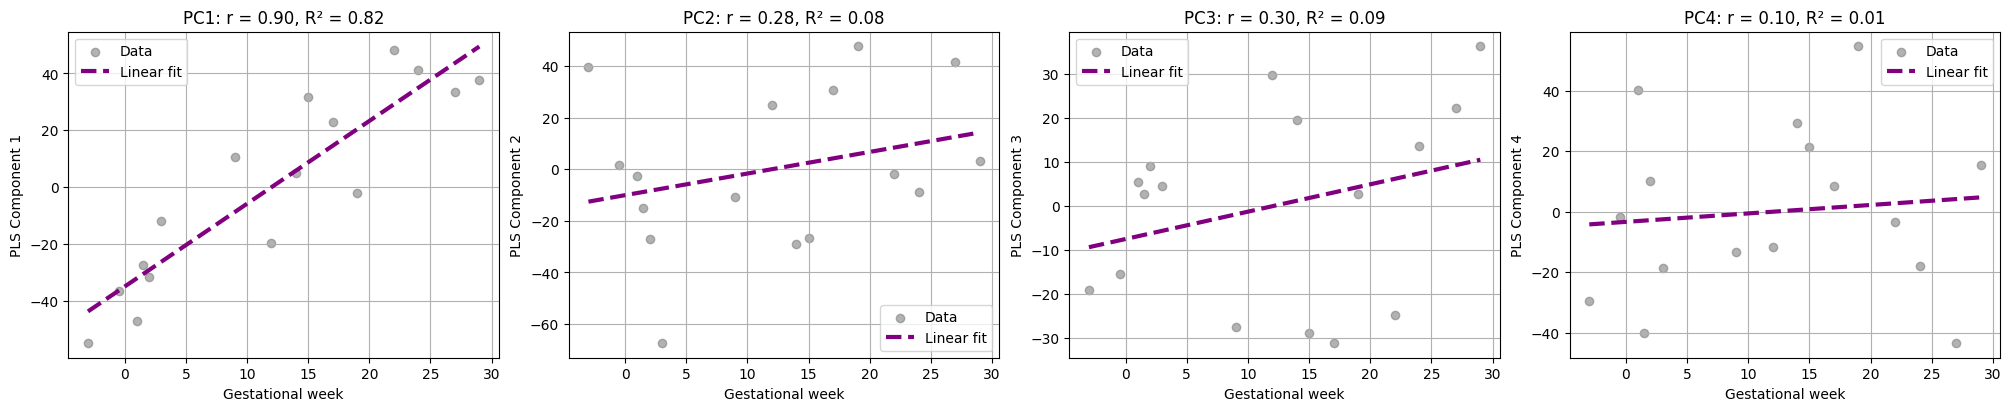

In [10]:
n_comps = 4
n_sessions = 16
fig, axes = plt.subplots(1, n_comps, figsize=(5 * n_comps, 4), constrained_layout=True)

for structure_id, structure_name in [(17,'Left-Hippocampus')]:
    aligned_meshes = all_meshes[structure_id]
    all_mesh_points = []
    for session_id in range(n_sessions):
        mesh = aligned_meshes[session_id]
        all_mesh_points.append(mesh.points)

    weeks_y = weeks[:n_sessions]

    # Flatten and scale meshes
    verts_reshaped = np.array(all_mesh_points).reshape(n_sessions, -1)
    # print(verts_reshaped.shape)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(verts_reshaped)

    y = weeks_y.reshape(-1, 1)
    # print(y.shape)

    # PLS: shape → week
    pls = PLSRegression(n_components=n_comps)
    pls.fit(X_scaled, y)
    pls_scores = pls.x_scores_

    # Overall R² for full model
    r2_total = pls.score(X_scaled, y)
    print(f"\nGlobal R² for predicting week from shape: {r2_total:.3f}")

    # Train week → PLS component regression
    reg = LinearRegression().fit(y, pls_scores)

    # Predict shape at specific weeks (example: 20, 25, 30, 35)
    weeks_to_predict = [31, 33, 36]
    predicted_meshes = {}
    for w in weeks_to_predict:
        scores_pred = reg.predict([[w]])  # predict shape latent vector
        X_pred_scaled = np.dot(scores_pred, pls.x_loadings_.T)
        X_pred = scaler.inverse_transform(X_pred_scaled)
        mesh_pred = X_pred.reshape(-1, 3)
        predicted_meshes[w] = mesh_pred  # store reconstructed mesh

    # Plot PLS components vs. week
    for comp in range(n_comps):
        ax = axes[comp]
        y_comp = pls_scores[:, comp]
        x_week = y

        # Correlation
        corr, pval = pearsonr(y_comp, weeks_y)

        # Fit regression line
        # print(x_week.shape)
        # print(y_comp.shape)

        lr = LinearRegression().fit(x_week, y_comp)
        y_fit = lr.predict(x_week)
        r2 = r2_score(y_comp, y_fit)

        # Print stats
        print(f"Component {comp+1}: r = {corr:.3f}, p = {pval:.7f}, R² = {r2:.3f}")

        # Plot scatter + regression
        ax.scatter(weeks_y, y_comp, label='Data', color='gray', alpha=0.6)
        x_line = np.linspace(x_week.min(), x_week.max(), 100).reshape(-1, 1)
        y_line = lr.predict(x_line)
        ax.plot(x_line, y_line, color='purple', linestyle='--', label='Linear fit', linewidth=3)

        ax.set_xlabel("Gestational week")
        ax.set_ylabel(f"PLS Component {comp + 1}")
        ax.set_title(f"PC{comp+1}: r = {corr:.2f}, R² = {r2:.2f}")
        ax.grid(True)
        ax.legend()

plt.show()

In [11]:
predicted_meshes

{31: array([[153.42254852, 135.6801313 , 110.56187129],
        [153.83179921, 136.07319177, 110.54639428],
        [153.24037114, 133.99172179, 111.17449628],
        ...,
        [142.67008429, 149.29034764, 146.82444422],
        [143.38455235, 149.53360674, 147.19375275],
        [143.00219932, 148.93483418, 147.34624818]], shape=(2502, 3)),
 33: array([[153.43249437, 135.70965979, 110.56201269],
        [153.84195696, 136.09651918, 110.5467509 ],
        [153.24908741, 134.01366738, 111.17040708],
        ...,
        [142.67341645, 149.26816225, 146.79227801],
        [143.39363167, 149.51572857, 147.16137758],
        [143.00866972, 148.92219036, 147.31496925]], shape=(2502, 3)),
 36: array([[153.44741315, 135.75395254, 110.5622248 ],
        [153.85719359, 136.13151031, 110.54728583],
        [153.26216181, 134.04658578, 111.16427328],
        ...,
        [142.67841469, 149.23488417, 146.7440287 ],
        [143.40725064, 149.48891132, 147.11281482],
        [143.01837533, 148.

In [30]:
for week in weeks_to_predict:
    print(X[X == week].index[0])
    m = all_meshes[17][X[X == week].index[0]].points
    print(m.shape)

16
(2502, 3)
17
(2502, 3)
18
(2502, 3)


In [33]:
def compute_rmsd(pred, true):
    """Compute root mean square deviation between two meshes."""
    assert pred.shape == true.shape
    return np.sqrt(np.mean(np.sum((pred - true) ** 2, axis=1)))

def compute_diameter(mesh):
    """Compute mesh diameter as max pairwise vertex distance (slow but simple)."""
    from scipy.spatial.distance import pdist
    return np.max(pdist(mesh))

print("\nRMSD Errors (normalized by mesh diameter):")
for week in weeks_to_predict:
    pred_mesh = predicted_meshes[week]

    # Find the closest ground truth week
    idx = np.argmin(np.abs(weeks - week))
    true_mesh = all_meshes[17][X[X == week].index[0]].points

    rmsd = compute_rmsd(pred_mesh, true_mesh)
    diameter = compute_diameter(true_mesh)
    rel_error = rmsd / diameter

    print(f"  Week {week}: RMSD = {rmsd:.4f}, Diameter = {diameter:.4f}, Relative Error = {rel_error:.2%}")



RMSD Errors (normalized by mesh diameter):
  Week 31: RMSD = 0.5761, Diameter = 42.9102, Relative Error = 1.34%
  Week 33: RMSD = 0.4808, Diameter = 42.8595, Relative Error = 1.12%
  Week 36: RMSD = 0.3770, Diameter = 42.7028, Relative Error = 0.88%


In [43]:

def show_overlay_meshes(true_mesh, predicted_mesh, faces, week=None):
    """
    Show predicted vs. true mesh overlayed in 3D.
    """
    mesh_true = pv.PolyData(true_mesh, faces)
    mesh_pred = pv.PolyData(predicted_mesh, faces)

    plotter = pv.Plotter(window_size=(700, 600))

    plotter.add_mesh(mesh_true, color='blue', opacity=0.2, label="Ground Truth")
    plotter.add_mesh(mesh_pred, color='red', opacity=0.2, label="Prediction")
    
    if week is not None:
        plotter.add_text(f"Overlay at Week {week}", position='upper_edge', font_size=14)

    plotter.add_legend()
    plotter.show()

week = 31
pred = predicted_meshes[week]
true = all_meshes[17][X[X == week].index[0]].points

show_overlay_meshes(true, pred, faces, week=week)


Widget(value='<iframe src="http://localhost:56910/index.html?ui=P_0x33a643410_10&reconnect=auto" class="pyvist…

In [44]:
import pyvista as pv
import numpy as np

def show_mesh_error_arrows(true_mesh, predicted_mesh, faces, week=None, scale=1.0):
    """
    Show arrows from true_mesh to predicted_mesh to visualize pointwise errors.
    
    Parameters:
    - true_mesh: (N, 3) ground truth points
    - predicted_mesh: (N, 3) predicted points
    - faces: VTK-style flattened face array
    - week: optional label to show in the viewer
    - scale: factor to scale arrow lengths for visibility
    """
    assert true_mesh.shape == predicted_mesh.shape

    # Compute displacement vectors (pred - true)
    vectors = predicted_mesh - true_mesh
    magnitudes = np.linalg.norm(vectors, axis=1)

    # Create PyVista mesh from true points
    base = pv.PolyData(true_mesh, faces)
    base["vectors"] = vectors
    base["error"] = magnitudes

    # Create glyphs (arrows)
    arrows = base.glyph(orient="vectors", scale="error", factor=scale)

    # Plot
    plotter = pv.Plotter(window_size=(800, 600))
    plotter.add_mesh(base, color='lightgray', opacity=0.5, label='Ground Truth')
    plotter.add_mesh(arrows, color='red', label='Error Vectors')

    if week is not None:
        plotter.add_text(f"Error Arrows at Week {week}", position="upper_edge", font_size=14)

    plotter.add_legend()
    plotter.show()

week = 31
pred = predicted_meshes[week]
true = all_meshes[17][X[X == week].index[0]].points

show_mesh_error_arrows(true, pred, faces, week=week, scale=2.0)


Widget(value='<iframe src="http://localhost:56910/index.html?ui=P_0x335fb5b50_11&reconnect=auto" class="pyvist…

In [45]:
from ipywidgets import interact, IntSlider

for structure_id, structure_name in [(17,'Left-Hippocampus')]:
    aligned_meshes = all_meshes[structure_id]
    all_mesh_points = []
    for session_id in range(n_sessions):
        mesh = aligned_meshes[session_id]
        all_mesh_points.append(mesh.points)
    weeks = weeks[0:n_sessions]
    verts_reshaped = np.array(all_mesh_points).reshape(len(all_mesh_points), 3 * len(all_mesh_points[0]))

    # Step 1: Get mean shape and component directions
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(verts_reshaped)
    
    mean_shape = scaler.mean_
    weights = pls.x_weights_  # shape: (n_features, n_components)
    
    comp_id = 0  # 0-based index for component
    alpha = 3  # exaggeration factor for visualization
    
    direction = weights[:, comp_id]  # shape (n_vertices * 3,)
    
    # Mean ± alpha × component
    shape_plus = mean_shape + alpha * direction
    shape_minus = mean_shape - alpha * direction
    
    shape_mean = mean_shape.reshape(-1, 3)
    shape_plus = shape_plus.reshape(-1, 3)
    shape_minus = shape_minus.reshape(-1, 3)

def interactive_pls_slider(
    mean_shape, direction, faces,
    alpha_max=30.0, n_frames=60, comp_id=0
):
    alphas = np.linspace(-alpha_max, alpha_max, n_frames)
    meshes = []

    max_disp = np.max(np.linalg.norm(alpha_max * direction, axis=1))
    scalar_range = (-max_disp, max_disp)

    # Precompute all deformed meshes
    for alpha in alphas:
        deformed = mean_shape + alpha * direction
        deformed = deformed.reshape(-1, 3)
        # displacement = np.linalg.norm(alpha * direction, axis=1)
        displacement = np.dot(direction, np.ones(3)) * alpha  # signed magnitude
        mesh = pv.PolyData(deformed, faces)
        mesh["Displacement"] = displacement
        meshes.append(mesh)

    # Create a plotter for Jupyter
    plotter = pv.Plotter(notebook=True)
    # actor = plotter.add_mesh(meshes[0], scalars="Displacement", cmap="coolwarm") # change to red-blue divergent color map
    # Add mesh with fixed colormap range
    actor = plotter.add_mesh(
        meshes[0],
        scalars="Displacement",
        cmap="coolwarm",
        clim=scalar_range
    )
    plotter.add_title(f"PLS Component {comp_id + 1} | alpha = {alphas[0]:.2f}", font_size=10)
    # text_actor = plotter.add_text(f"PLS Component {comp_id + 1} | alpha = {alphas[0]:.2f}", font_size=10)
    plotter.show(auto_close=False)

    # Slider function
    def update(frame_idx):
        mesh = meshes[frame_idx]
        actor.mapper.SetInputData(mesh)
        # text_actor.SetText(0, f"PLS Component {comp_id + 1} | alpha = {alphas[frame_idx]:.2f}")
        plotter.add_title(f"PLS Component {comp_id + 1} | alpha = {alphas[frame_idx]:.2f}", font_size=10)
        plotter.render()

    interact(update, frame_idx=IntSlider(min=0, max=n_frames - 1, step=1, value=0))


interactive_pls_slider(mean_shape.reshape(-1, 3), direction.reshape(-1, 3), faces, comp_id=0)


Widget(value='<iframe src="http://localhost:56910/index.html?ui=P_0x33d553410_12&reconnect=auto" class="pyvist…

interactive(children=(IntSlider(value=0, description='frame_idx', max=59), Output()), _dom_classes=('widget-in…

In [47]:
import pyvista as pv
import numpy as np
from scipy.spatial.distance import pdist

def compute_rmsd(pred, true):
    return np.sqrt(np.mean(np.sum((pred - true) ** 2, axis=1)))

def compute_diameter(mesh):
    return np.max(pdist(mesh))

def visualize_pointwise_error_row(predicted_meshes, weeks_to_predict, all_meshes, weeks, X):
    """
    Show pointwise error plots in a row for multiple predicted meshes.
    Titles include percent error relative to mesh diameter.
    """
    n = len(weeks_to_predict)
    plotter = pv.Plotter(shape=(1, n), window_size=(350 * n, 500))

    for i, week in enumerate(weeks_to_predict):
        pred_mesh = predicted_meshes[week]

        # Get ground truth mesh
        idx = np.argmin(np.abs(weeks - week))
        true_mesh = all_meshes[17][X[X == week].index[0]]
        true_points = true_mesh.points
        faces = true_mesh.faces

        # Compute error map
        error = np.linalg.norm(pred_mesh - true_points, axis=1)
        mesh = pv.PolyData(pred_mesh, faces)
        mesh["Error"] = error

        # Compute normalized error
        rmsd = compute_rmsd(pred_mesh, true_points)
        diameter = compute_diameter(true_points)
        rel_error = 100 * rmsd / diameter

        # Add subplot
        plotter.subplot(0, i)
        plotter.add_mesh(mesh, scalars="Error", cmap="plasma", show_edges=False)
        plotter.add_text(f"Week {week} — {rel_error:.3f}%", font_size=10)
        plotter.view_xy()

    plotter.link_views()
    plotter.show()

visualize_pointwise_error_row(predicted_meshes, weeks_to_predict, all_meshes, weeks, X)


Widget(value='<iframe src="http://localhost:56910/index.html?ui=P_0x326c1b410_14&reconnect=auto" class="pyvist…

In [52]:
n_comps = 4
n_sessions = 16

for structure_id, structure_name in structure_key.items():
    aligned_meshes = all_meshes[structure_id]
    all_mesh_points = []
    for session_id in range(n_sessions):
        mesh = aligned_meshes[session_id]
        all_mesh_points.append(mesh.points)

    weeks_y = weeks[:n_sessions]

    # Flatten and scale meshes
    verts_reshaped = np.array(all_mesh_points).reshape(n_sessions, -1)
    # print(verts_reshaped.shape)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(verts_reshaped)

    y = weeks_y.reshape(-1, 1)
    # print(y.shape)

    # PLS: shape → week
    pls = PLSRegression(n_components=n_comps)
    pls.fit(X_scaled, y)
    pls_scores = pls.x_scores_

    # Overall R² for full model
    r2_total = pls.score(X_scaled, y)
    
    print(f"\nStructure {structure_name}")
    print(f"Global R² for predicting week from shape: {r2_total:.3f}")

    # Train week → PLS component regression
    reg = LinearRegression().fit(y, pls_scores)

    # Predict shape at specific weeks (example: 20, 25, 30, 35)
    weeks_to_predict = [31, 33, 36]
    predicted_meshes = {}
    for w in weeks_to_predict:
        scores_pred = reg.predict([[w]])  # predict shape latent vector
        X_pred_scaled = np.dot(scores_pred, pls.x_loadings_.T)
        X_pred = scaler.inverse_transform(X_pred_scaled)
        mesh_pred = X_pred.reshape(-1, 3)
        predicted_meshes[w] = mesh_pred  # store reconstructed mesh

    # Plot PLS components vs. week
    for comp in range(n_comps):
        y_comp = pls_scores[:, comp]
        x_week = y

        # Correlation
        corr, pval = pearsonr(y_comp, weeks_y)

        # Fit regression line
        # print(x_week.shape)
        # print(y_comp.shape)

        lr = LinearRegression().fit(x_week, y_comp)
        y_fit = lr.predict(x_week)
        r2 = r2_score(y_comp, y_fit)

        # Print stats
        print(f"Component {comp+1}: r = {corr:.3f}, p = {pval:.7f}, R² = {r2:.3f}")

        # Plot scatter + regression
        x_line = np.linspace(x_week.min(), x_week.max(), 100).reshape(-1, 1)
        y_line = lr.predict(x_line)





Structure Left-Thalamus-Proper
Global R² for predicting week from shape: 0.999
Component 1: r = 0.919, p = 0.0000005, R² = 0.845
Component 2: r = 0.309, p = 0.2443175, R² = 0.095
Component 3: r = -0.213, p = 0.4279486, R² = 0.045
Component 4: r = -0.111, p = 0.6827352, R² = 0.012

Structure Left-Caudate
Global R² for predicting week from shape: 0.998
Component 1: r = 0.823, p = 0.0000887, R² = 0.678
Component 2: r = 0.530, p = 0.0349002, R² = 0.280
Component 3: r = -0.182, p = 0.4987409, R² = 0.033
Component 4: r = -0.079, p = 0.7706332, R² = 0.006

Structure Left-Putamen
Global R² for predicting week from shape: 0.998
Component 1: r = -0.832, p = 0.0000652, R² = 0.692
Component 2: r = -0.515, p = 0.0411618, R² = 0.265
Component 3: r = 0.189, p = 0.4824758, R² = 0.036
Component 4: r = -0.070, p = 0.7976478, R² = 0.005

Structure Left-Pallidum
Global R² for predicting week from shape: 0.999
Component 1: r = -0.912, p = 0.0000008, R² = 0.832
Component 2: r = 0.355, p = 0.1777642, R² = 0